# cartopy+shapefile

AMeDASの地点をプロットしてみる。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
data = pd.read_csv('./data/chiten.csv', encoding='shift-jis')

In [3]:
data.head()

,lon,lat,chiten
0,139.7500,35.6917,Tokyo
1,139.3617,34.7483,Ohshima
2,139.6517,35.4383,Yokohama
3,139.8650,34.9867,Tateyama
4,140.3117,35.1500,Katsuura


In [4]:
frame = './data/gadm36_JPN_shp/gadm36_JPN_1.shp'
shape = list(shpreader.Reader(frame).geometries())

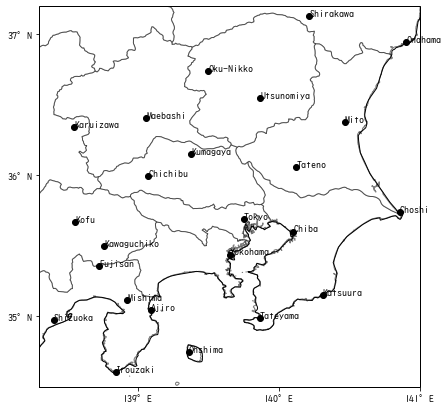

In [5]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=crs.PlateCarree())
ax.add_geometries(shape, crs.PlateCarree(), edgecolor='black', facecolor='white', alpha=0.5)
ax.coastlines(resolution='10m')
ax.set_extent([138.3, 141.0, 34.5, 37.2])
ax.set_xticks([139,140,141], crs=crs.PlateCarree())
ax.set_yticks([35,36,37], crs=crs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

for x,y,name in zip(data['lon'], data['lat'], data['chiten']):
    ax.text(x,y,name)
    ax.plot(x,y,'ko')#ko:黒丸
    
plt.show()

気温をプロットしてみる。

In [6]:
data2 = pd.read_csv('./data/chiten_07081614.csv', encoding='shift_jis')

In [7]:
data2.head()

,lon,lat,temp,ws,wd,chiten
0,139.7500,35.6917,35.9,3.8,202.5,Tokyo
1,139.3617,34.7483,29.6,4.6,202.5,Ohshima
2,139.6517,35.4383,35.4,5.0,180.0,Yokohama
3,139.8650,34.9867,31.1,2.6,202.5,Tateyama
4,140.3117,35.1500,31.6,2.4,202.5,Katsuura


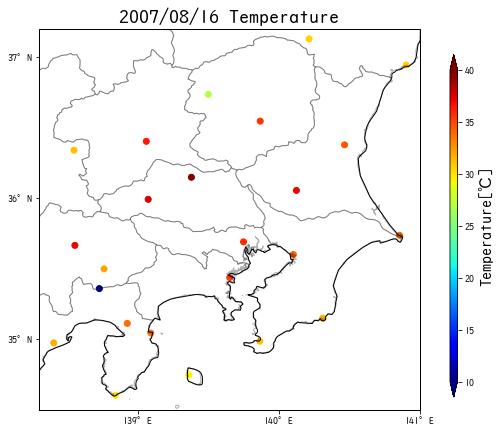

In [8]:
fig = plt.figure(figsize=(7,7))

#---地図描く---
ax2 = plt.axes(projection=crs.PlateCarree())
ax2.add_geometries(shape, crs.PlateCarree(), edgecolor='black', facecolor='none', alpha=0.3)
ax2.coastlines(resolution='10m')
ax2.set_extent([138.3,141.0,34.5,37.2])

#---x,y軸を°Eや°N表記にする---
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

#---オプション---
ax2.set_title('2007/08/16 Temperature', fontsize=20)
ax2.set_xticks([139,140,141], crs=crs.PlateCarree())
ax2.set_yticks([35,36,37], crs=crs.PlateCarree())

#---カラーバーつくる---
cm = ax2.scatter(data2['lon'], data2['lat'], c=data2['temp'], vmin=10, vmax=40, cmap=plt.get_cmap('jet'))
cax = fig.add_axes([0.95, 0.15, 0.015, 0.68])
cbar = plt.colorbar(cm, cax, extend='both')
cbar.set_label('Temperature[℃]', fontsize=16)

plt.show()

風のベクトルプロットしてみる

In [9]:
import numpy as np
from matplotlib.colors import Normalize
import cartopy.feature as cfeature

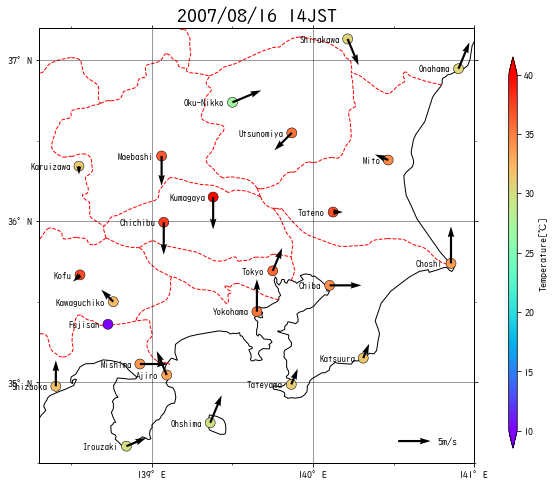

In [10]:
data2.loc[data2["ws"]<=0, "ws"] = np.nan
data2.loc[data2["wd"]<=0, "wd"] = np.nan

U = data2["ws"] * np.sin(np.radians(data2["wd"]) + np.pi)
V = data2["ws"] * np.cos(np.radians(data2["wd"]) + np.pi)

lon = data2["lon"]
lat = data2["lat"]
TMP = data2["temp"]
place = data2["chiten"]

states_10m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '10m', 
                                          edgecolor='r', facecolor='w', linestyle='--')

wlon, elon, slat, nlat = 138.3, 141, 34.5, 37.2

proj = crs.PlateCarree()

fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111,projection=proj)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)

ax3.set_extent([wlon,elon,slat,nlat], proj)
ax3.coastlines(resolution='10m')
ax3.add_feature(states_10m)
ax3.set_xticks(np.arange(139,141+1,1), crs=proj)
ax3.set_yticks(np.arange(35,37+1, 1), crs=proj)
ax3.set_xticks(np.arange(138.5,141+0.5,0.5), minor=True, crs=proj)
ax3.set_yticks(np.arange(34.5,37+0.5,0.5), minor=True, crs=proj)
ax3.tick_params(direction='out', which='major', labelsize=10)
ax3.xaxis.set_ticks_position('both')
ax3.yaxis.set_ticks_position('both')
ax3.grid(which='major', color='k', alpha=0.8, ls='-', lw=0.5, zorder=1)

cmaps = plt.cm.get_cmap('rainbow')
tmp = ax3.scatter(lon, lat, 100, TMP, edgecolor='k', lw=0.5, cmap=cmaps,
                 norm=Normalize(vmin=10, vmax=40), zorder=2)
ver = ax3.quiver(lon, lat, U, V, transform=proj, width=0.005, zorder=3)
qu = ax3.quiverkey(ver, 0.9, 0.05, 5, r'5m/s', labelpos='E',
                  coordinates='axes', transform=proj)

imax = len(place)
for i in range(0,imax):
    ax3.text(lon[i]-0.05, lat[i], place[i], ha='right', va='center', fontsize=9)
    
cax = fig.add_axes([0.95, 0.15, 0.015, 0.68])
cbar = plt.colorbar(tmp, cax, extend='both')
cbar.set_label("Temperature[℃]", fontsize=10)

ax3.set_title('2007/08/16 14JST', fontsize=20)
plt.show()

東京23区の地図＋AMeDAS地点つくる

In [11]:
fname1 = './data/kanto/Kanto.shp'
fname2 = './data/special_wards/special_ward.shp'

In [12]:
adm1_shapes = list(shpreader.Reader(fname1).geometries())
adm2_shapes = list(shpreader.Reader(fname2).geometries())

df = pd.read_csv('./data/AMeDAS_tokyo.csv', header=0)

In [13]:
df

,lon,lat,place
0,139.750,35.692,Tokyo
1,139.863,35.638,Edogawa-Rinkai
2,139.780,35.553,Haneda
3,139.620,35.627,Setagaya
4,139.592,35.738,Nerima
5,139.483,35.683,Fuchu


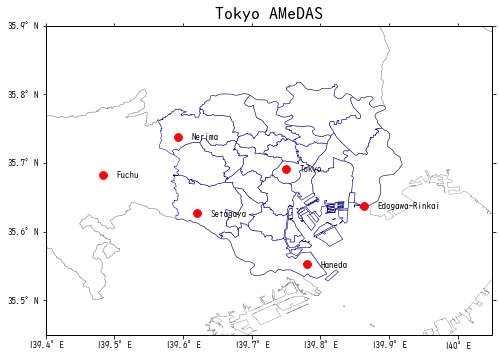

In [14]:
lon = df['lon']
lat = df['lat']
place = df['place']

wlon, elon, slat, nlat = 139.4, 140.05, 35.45, 35.9

proj = crs.PlateCarree()
fig = plt.figure(figsize=(8,8))
ax4 = fig.add_subplot(111, projection=proj)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)

ax4.set_extent([wlon, elon, slat, nlat], proj)

ax4.add_geometries(adm1_shapes, proj, facecolor='w', alpha=0.8, lw=0.5, edgecolor='gray')
ax4.add_geometries(adm2_shapes, proj, facecolor='w', alpha=1, lw=0.5, edgecolor='darkblue')

ax4.scatter(lon, lat, 60, c='r', zorder=2)
imax = len(place)
for i in range(0, imax):
    ax4.text(lon[i]+0.02, lat[i], place[i], ha='left', va='center', fontsize=9)
    
ax4.set_xticks(np.arange(139.4, 140+0.1, 0.1))
ax4.set_yticks(np.arange(35.5, 35.9+0.1, 0.1))
ax4.xaxis.set_ticks_position('both')
ax4.yaxis.set_ticks_position('both')
ax4.tick_params(direction='out', which='major', labelsize=9)
ax4.set_title('Tokyo AMeDAS', fontsize=18)

plt.show()

#plt.savefig('sample.png', bbox_inches='tight', pad_inches=0.05)